In [1]:
!pip install mesa numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.5 MB/s eta 0:00:00




**Modifiche**

**Figura 7: (self-matching OFF, aggiornamento asincrono)**

Qui il cambiamento più importante è nell’aggiornamento asincrono: gli agenti si aggiornano uno per volta in ordine casuale.

Risultato:

- I **cambiamenti di strategia sono più lenti e sparsi, e non avvengono “a ondate”**.

- Il grafico è **molto misto**: più verde e giallo, segno di instabilità strategica.

- La cooperazione fa fatica a stabilizzarsi, nonostante alcune isole blu.




Complessivamente, l’aggiornamento asincrono rende più difficile la formazione di gruppi cooperanti stabili

Simulazione (m=inf, b=1.02) completata in 9.6s
Simulazione (m=inf, b=1.15) completata in 9.7s
Simulazione (m=inf, b=1.19) completata in 9.7s
Simulazione (m=inf, b=1.23) completata in 9.9s
Simulazione (m=inf, b=1.3) completata in 9.1s
Simulazione (m=inf, b=1.35) completata in 9.3s
Simulazione (m=inf, b=1.45) completata in 9.6s
Simulazione (m=inf, b=1.55) completata in 9.5s
Simulazione (m=inf, b=1.61) completata in 9.0s
Simulazione (m=inf, b=1.7) completata in 9.2s
Simulazione (m=100, b=1.02) completata in 9.6s
Simulazione (m=100, b=1.15) completata in 9.8s
Simulazione (m=100, b=1.19) completata in 11.4s
Simulazione (m=100, b=1.23) completata in 8.5s
Simulazione (m=100, b=1.3) completata in 9.6s
Simulazione (m=100, b=1.35) completata in 9.5s
Simulazione (m=100, b=1.45) completata in 9.6s
Simulazione (m=100, b=1.55) completata in 8.4s
Simulazione (m=100, b=1.61) completata in 9.4s
Simulazione (m=100, b=1.7) completata in 9.3s
Simulazione (m=20, b=1.02) completata in 9.2s
Simulazione (m=20

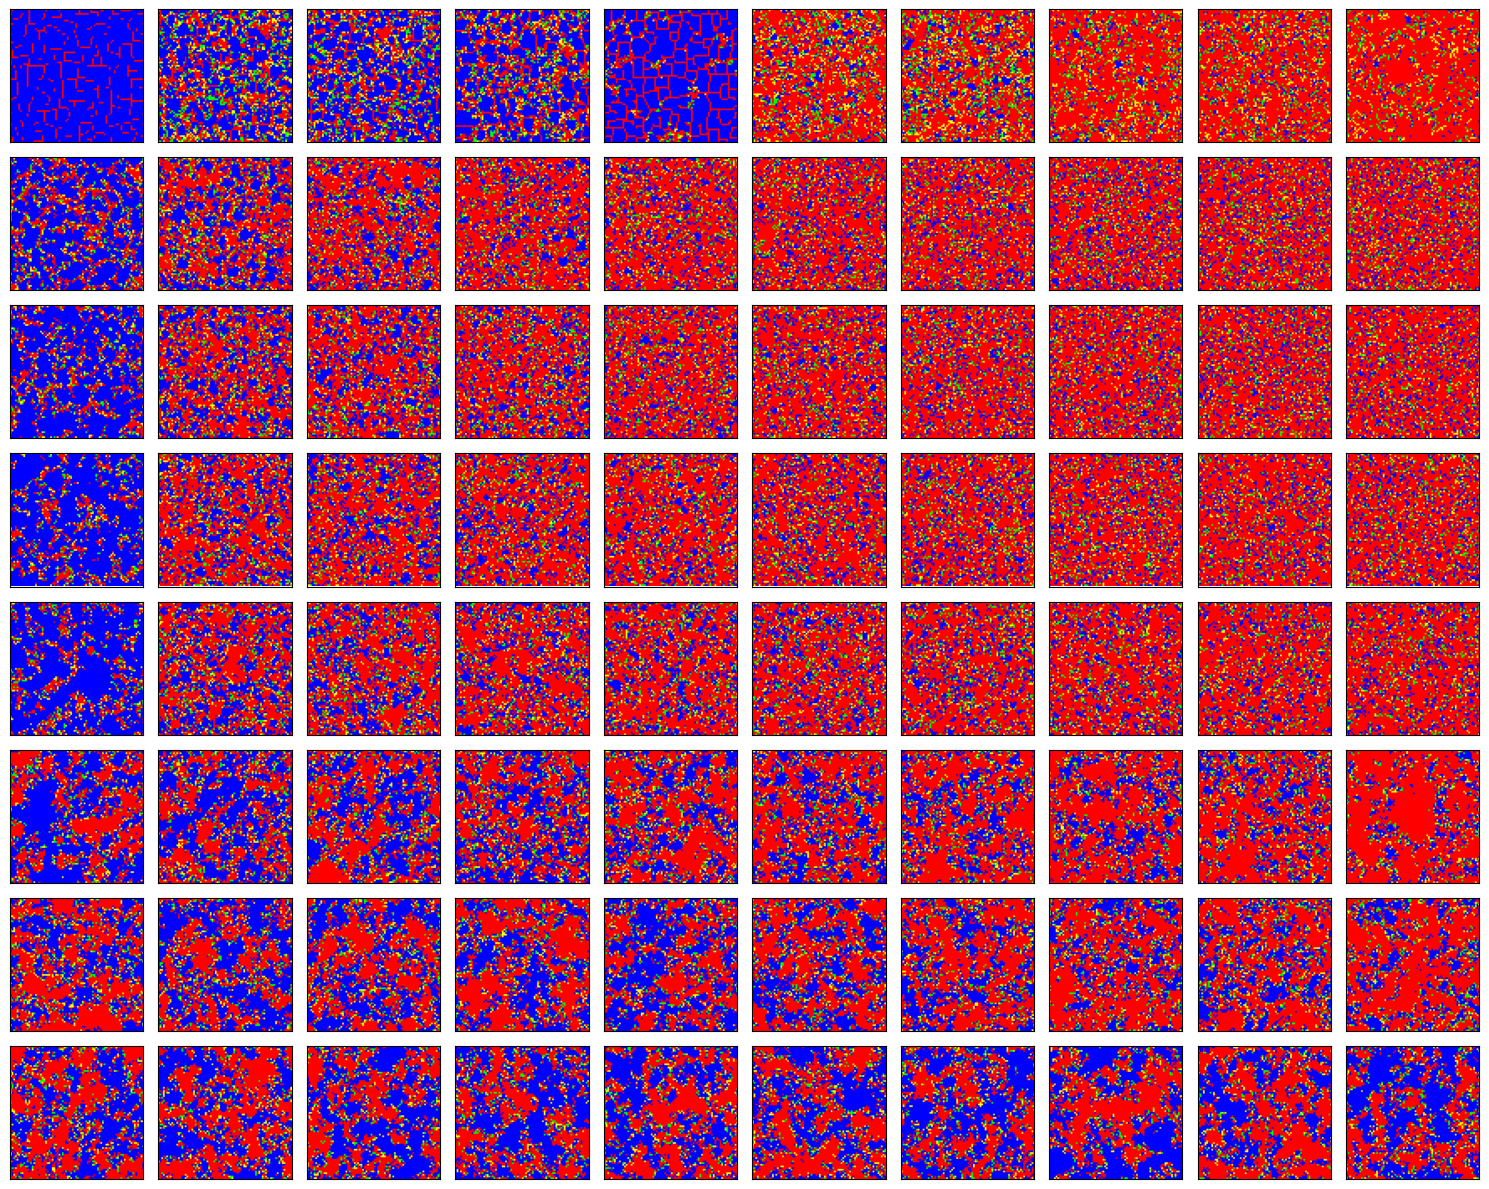

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time
import warnings

from mesa import Agent, Model
from mesa.space import MultiGrid

warnings.filterwarnings("ignore", category=UserWarning)

# ---------- Payoff Matrix ----------
def snowdrift_payoff_matrix(b):
    return [[1, 1 - 1 / b], [b, 0]]

# ---------- Agent Definition ----------
class PatchAgent(Agent):
    def __init__(self, model, unique_id, pos):
        super().__init__(model)
        self.unique_id = unique_id
        self.pos = pos
        self.strategy = None
        self.payoff = 0

    def compute_neighbors(self):
        self.my_coplayers = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=False, radius=1  # NO self-matching
        )
        self.n_of_my_coplayers = len(self.my_coplayers)

    def play(self):
        self.compute_neighbors()
        counts = [sum(1 for a in self.my_coplayers if a.strategy == i) for i in range(2)]
        my_payoffs = self.model.payoff_matrix[self.strategy]
        self.payoff = sum(p * c for p, c in zip(my_payoffs, counts))

    def update_strategy(self):
        m = self.model.m
        if m == float('inf'):
            best = max(self.my_coplayers + [self], key=lambda a: a.payoff)
            self.strategy = best.strategy
        else:
            opp = random.choice(self.my_coplayers) if self.my_coplayers else self
            diff = (opp.payoff - self.payoff) / self.n_of_my_coplayers if self.n_of_my_coplayers else 0
            prob = 1 / (1 + math.exp(-m * diff))
            self.strategy = opp.strategy if random.random() < prob else self.strategy

# ---------- Model Definition ----------
class GameModel(Model):
    def __init__(self, width, height, payoff_matrix, initial_distribution, m):
        super().__init__()
        self.grid = MultiGrid(width, height, torus=True)
        self.patch_agents = []
        self.payoff_matrix = np.array(payoff_matrix)
        self.n_of_players = width * height
        self.m = m

        uid = 0
        for x in range(width):
            for y in range(height):
                agent = PatchAgent(self, uid, (x, y))
                self.grid.place_agent(agent, (x, y))
                self.patch_agents.append(agent)
                uid += 1
        self._setup_strategies(initial_distribution)

    def _setup_strategies(self, distribution):
        agents = self.patch_agents.copy()
        random.shuffle(agents)
        idx = 0
        for strat, count in enumerate(distribution):
            for _ in range(count):
                agents[idx].strategy = strat
                idx += 1
    #aggiornamento asincrono
    def step(self):
        agent = random.choice(self.patch_agents)
        agent.play()
        agent.update_strategy()

# ---------- Simulation Grid Generation ----------
def generate_figure():
    width = height = 80
    steps = width * height * 100  # ~100 full-lattice updates
    m_values = [float('inf'), 100, 20, 10, 5, 1, 0.5, 0]
    b_values = [1.02, 1.15, 1.19, 1.23, 1.3, 1.35, 1.45, 1.55, 1.61, 1.7]

    fig, axes = plt.subplots(len(m_values), len(b_values), figsize=(15, 12))

    for row, m in enumerate(m_values):
        for col, b in enumerate(b_values):
            start = time.time()
            matrix = snowdrift_payoff_matrix(b)
            distribution = [width * height // 2, width * height // 2]
            model = GameModel(width, height, matrix, distribution, m=m)

            for _ in range(steps):
                model.step()

            final = np.zeros((width, height))
            prev_strategies = {a.unique_id: a.strategy for a in model.patch_agents}
            for _ in range(width * height):
                model.step()

            prev = np.zeros((width, height))
            for agent in model.patch_agents:
                x, y = agent.pos
                final[x, y] = agent.strategy
                prev[x, y] = prev_strategies[agent.unique_id]

            image = np.zeros((width, height, 3))
            for x in range(width):
                for y in range(height):
                    if final[x, y] == 0 and prev[x, y] == 0:
                        image[x, y] = [0, 0, 1]  # blue
                    elif final[x, y] == 1 and prev[x, y] == 1:
                        image[x, y] = [1, 0, 0]  # red
                    elif final[x, y] == 1 and prev[x, y] == 0:
                        image[x, y] = [0, 1, 0]  # green
                    elif final[x, y] == 0 and prev[x, y] == 1:
                        image[x, y] = [1, 1, 0]  # yellow

            ax = axes[row][col]
            ax.imshow(image.transpose((1, 0, 2)), origin='lower')
            ax.set_xticks([])
            ax.set_yticks([])
            print(f"Simulazione (m={m}, b={b}) completata in {time.time() - start:.1f}s")

    plt.tight_layout()
    plt.show()

# Run the full figure
generate_figure()
